# Evasion attacks in ART

based on the medium article: [Link](https://kedion.medium.com/ml-security-with-the-adversarial-robustness-toolbox-d173b24e8c1a)

## Importing dependencies

In [1]:
!pip install adversarial-robustness-toolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.9 MB/s eta 0:00:00


In [2]:
# Importing dependencies
import tensorflow as tf
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
#import adversarial-robustness-toolbox as art

from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod
from art.utils import load_dataset


# Increasing Matplotlib font size
matplotlib.rcParams.update({"font.size": 14})


## Loading data

In [3]:
# Loading the data
(train_images, train_labels), (test_images, test_labels), min, max = load_dataset(name="mnist")

##Training a TensorFlow Keras model

In [4]:
# Function for creating model
def create_model():
    # Defining the model
    model = tf.keras.models.Sequential([
        Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(28, 28, 1)),
        MaxPool2D(pool_size=2),
        Conv2D(filters=64, kernel_size=3, activation="relu"),
        MaxPool2D(pool_size=2),
        Flatten(),
        Dense(units=10, activation="softmax")
    ])

    # Compiling the model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
        )

    # Returning the model
    return model

In [ ]:
# Instantiating the model
model = create_model()

# Training the model
model.fit(
    x=train_images,
    y=train_labels,
    epochs=10,
    batch_size=256)

Epoch 1/10
235/235 [==============================] - 59s 244ms/step - loss: 0.3755 - accuracy: 0.9043
Epoch 2/10
235/235 [==============================] - 48s 203ms/step - loss: 0.0824 - accuracy: 0.9749
Epoch 3/10
235/235 [==============================] - 45s 190ms/step - loss: 0.0621 - accuracy: 0.9809
Epoch 4/10
235/235 [==============================] - 44s 186ms/step - loss: 0.0504 - accuracy: 0.9841
Epoch 5/10
235/235 [==============================] - 44s 186ms/step - loss: 0.0441 - accuracy: 0.9862
Epoch 6/10
235/235 [==============================] - 45s 192ms/step - loss: 0.0385 - accuracy: 0.9884
Epoch 7/10
235/235 [==============================] - 44s 187ms/step - loss: 0.0348 - accuracy: 0.9895
Epoch 8/10
235/235 [==============================] - 46s 196ms/step - loss: 0.0315 - accuracy: 0.9901
Epoch 9/10
235/235 [==============================] - 44s 187ms/step - loss: 0.0288 - accuracy: 0.9913
Epoch 10/10
235/235 [==============================] - 43s 185ms/step - l

## Defining an evasion attack on our model

In [ ]:
# Creating a classifier by wrapping our TF model in ART's KerasClassifier class
# create ART classifier object
loss_object = tf.keras.losses.CategoricalCrossentropy()
classifier = TensorFlowV2Classifier(clip_values=(0, 1), model=model, nb_classes=10, input_shape=(28, 28, 1), loss_object=loss_object,)


In [ ]:
# Defining an attack using the fast gradient method
attack_fgsm = FastGradientMethod(
    estimator=classifier,
    eps=0.3
    )

In [ ]:
# Generating adversarial images from test images
test_images_adv = attack_fgsm.generate(x=test_images)

## Evaluating the effectiveness of the attack

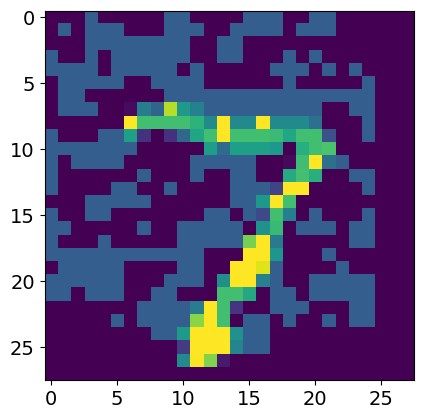

In [ ]:
# Viewing an adversarial image
plt.imshow(test_images_adv[0].squeeze())



In [ ]:
# Evaluating the model on clean images
score_clean = model.evaluate(
    x=test_images,
    y=test_labels
    )

# Evaluating the model on adversarial images
score_adv = model.evaluate(
    x=test_images_adv,
    y=test_labels
    )

# Comparing test losses
print(f"Clean test set loss: {score_clean[0]:.2f} "
      f"vs adversarial set test loss: {score_adv[0]:.2f}")

# Comparing test accuracies
print(f"Clean test set accuracy: {score_clean[1]:.2f} "
      f"vs adversarial test set accuracy: {score_adv[1]:.2f}")

313/313 [==============================] - 3s 8ms/step - loss: 6.8472 - accuracy: 0.0599
Clean test set loss: 0.04 vs adversarial set test loss: 6.85
Clean test set accuracy: 0.99 vs adversarial test set accuracy: 0.06


1/1 [==============================] - 0s 20ms/step


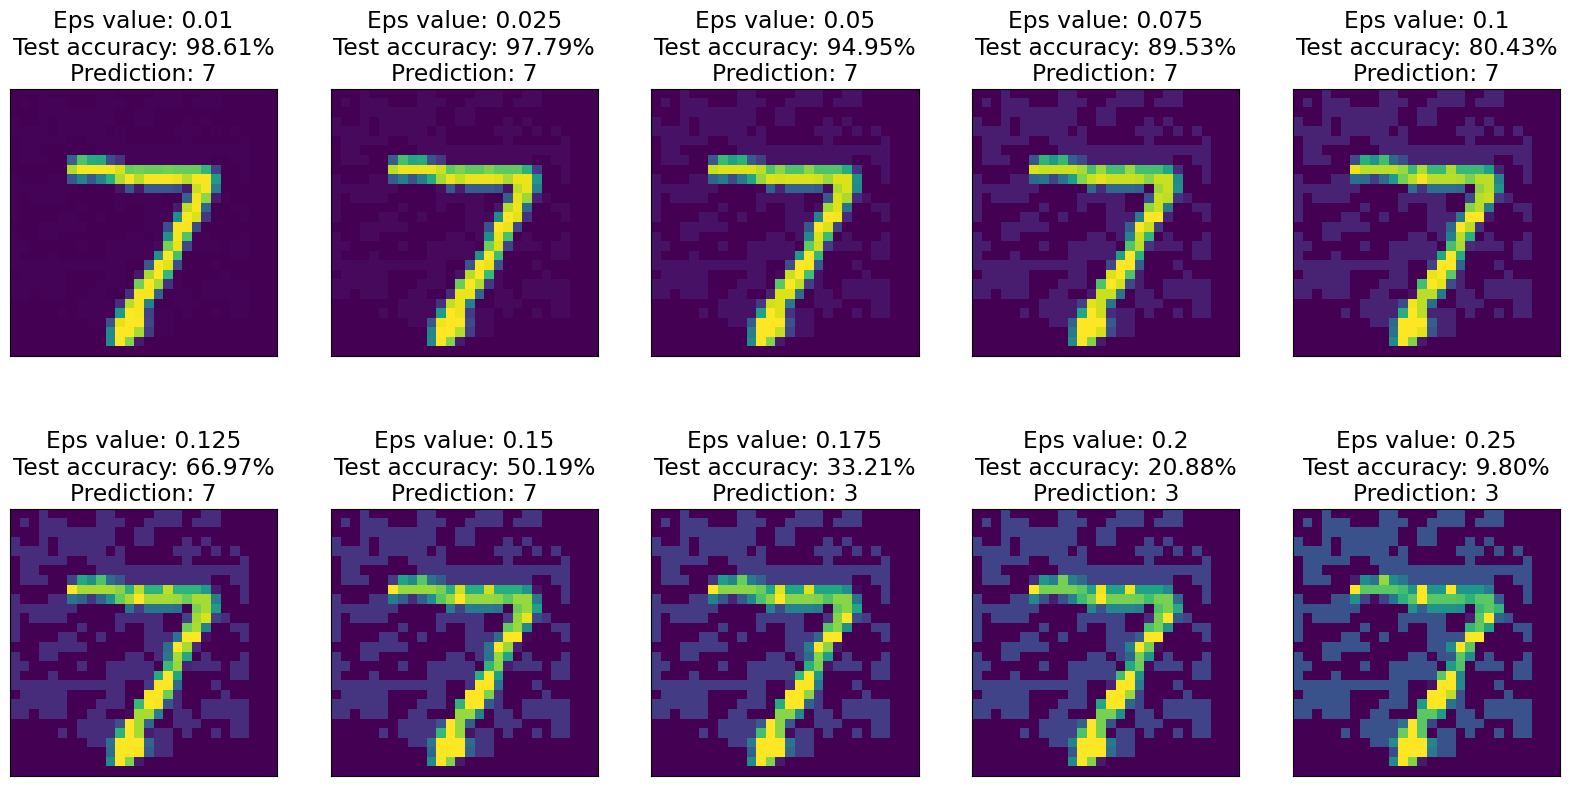

In [ ]:
# Setting the number of rows and columns for the figure
nrows, ncols = 2, 5

# Generating subplots
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(20, 10)
    )

# Defining a range of eps values to try
eps_to_try = [0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25]

# Defining a counting variable to traverse eps_to_try
counter = 0

# Iterating over rows and cols
for i in range(nrows):
    for j in range(ncols):
        # Creating an attack object for the current value of eps
        attack_fgsm = FastGradientMethod(
            estimator=classifier,
            eps=eps_to_try[counter]
            )

        # Generating adversarial images
        test_images_adv = attack_fgsm.generate(x=test_images)

        # Showing the first adversarial image
        axes[i, j].imshow(X=test_images_adv[0].squeeze())

        # Disabling x and y ticks
        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])

        # Evaluating model performance on adversarial samples and retrieving test accuracy
        test_score = classifier._model.evaluate(
            x=test_images_adv,
            y=test_labels
            )[1]

        # Getting prediction for the image that we displayed
        prediction = np.argmax(model.predict(
            x=np.expand_dims(a=test_images_adv[0],
            axis=0)
            ))

        # Showing the current eps value, test accuracy, and prediction
        axes[i, j].set_title(
            label=f"Eps value: {eps_to_try[counter]}\n"
            f"Test accuracy: {test_score * 100:.2f}%\n"
            f"Prediction: {prediction}"
            )

        # Incrementing counter
        counter += 1

# Showing the plot
plt.show()